In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
from model_fashion_mnist import Net, Net2c
import dset_fashion_mnist as dset
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = "True"
args.epochs = 100
args.lr = 0.0002

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 20

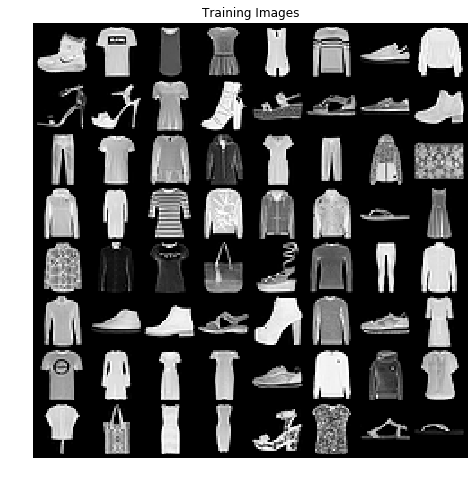

In [3]:
real_batch = iter(train_loader).next()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=20, nc=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf, kernel_size=13, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# model
netG = Generator().to(device)

# criterion
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

In [6]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(args.epochs):
    # For each batch in the dataloader
    for i, (data, target) in enumerate(train_loader, 0):
        b_size = data.shape[0]
        noise = torch.randn(b_size, nz, 1, 1, device=device) 
        data = data.to(device)
        data_ = netG(noise)
        # loss
        loss = criterion(data, data_)
        # zero grad
        netG.zero_grad()
        # backward
        loss.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % args.log_interval == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                       100. * i / len(train_loader), loss.data.item()), end='')

        # Save Losses for plotting later
        G_losses.append(loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == args.epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                im_gen = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(im_gen, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Train Epoch: 99 [0/60000 (0%)]	Loss: 0.089320

NameError: name 'dataloader' is not defined

In [ ]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# import matplotlib.animation as animation
# from IPython.display import HTML
# #%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())